In [1]:
# project: p5
# submitter: ejhickey3
# partner: none
# hours: 7

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import edgar_utils
import fnmatch
from zipfile import ZipFile, Path
import io
import os
import graphviz
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import re

In [4]:
server_log = pd.read_csv("server_log.zip")

In [5]:
#Q1: what's the total size in bytes of the files requested?

int(server_log["size"].sum())


24801002666

In [6]:
server_log["ip"].value_counts()[:10].to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [7]:
#Q2: how many filings have been accessed by the top ten IPs?

server_log["ip"].value_counts()[:10].to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

In [8]:
#Q3: what fraction of the requests had errors?
        
(server_log["code"] >= 400).sum() / len(server_log)

0.03466852724527611

In [9]:
#Q4: what is the most frequently accessed file?

cik = server_log["cik"].astype(int).astype(str)
accession = server_log["accession"]
extention = server_log["extention"]
SL_files = cik + "/" + accession + "/" + extention

SL_files.value_counts().index[0]

'1627631/0001627631-15-000004/.txt'

In [10]:
#Q5: how many requests were made by automated crawlers?

(server_log["crawler"] != 0).sum()

971

In [11]:
ip_dict = server_log["ip"].value_counts().to_dict()

In [12]:
#Q6: which region uses EDGAR most heavily?

regions_using_edgar = {}
for ip in ip_dict:
    region = edgar_utils.lookup_region(ip)
    if region not in regions_using_edgar:
        regions_using_edgar[region] = 0
    if region in regions_using_edgar:
        regions_using_edgar[region] += 1
        
regions = sorted(regions_using_edgar.items(), key=lambda x:x[1],reverse = True)
regions[0][0]

'United States of America'

In [13]:
region_ips = {}
amnt_region_ips = {}

for ip in ip_dict:
    region = edgar_utils.lookup_region(ip) 
    if region not in region_ips: 
        region_ips[region] = None
        
for key in region_ips:
    regional_ip = {}
    region_ips[key] = regional_ip
    for ip in ip_dict:
        region = edgar_utils.lookup_region(ip)
        if region == key:
            regional_ip[ip] = ip_dict[ip]
    amnt_region_ips[key] = len(regional_ip)
   
              

In [14]:
amnt_hv_region = {}
for region in region_ips:
    for ip in region_ips[region]:
        if region not in amnt_hv_region:
            amnt_hv_region[region] = 0
        if region_ips[region][ip] > 1000:
                amnt_hv_region[region] += 1
           

In [15]:
#Q7: what fraction of IPs in each region are high-volume users?

fraction_hv_regional = {}
for region in region_ips:
    if region not in fraction_hv_regional:
        fraction_hv_regional[region] = None
    fraction_hv_regional[region] = amnt_hv_region[region] / amnt_region_ips[region]
    
fraction_hv_regional

{'United States of America': 0.019862490450725745,
 'China': 0.006864988558352402,
 'India': 0.058823529411764705,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'Korea (Republic of)': 0.2,
 'Canada': 0.017857142857142856,
 'France': 0.0036900369003690036,
 'Bulgaria': 0.3333333333333333,
 'Ireland': 0.3125,
 'Australia': 0.07692307692307693,
 'Hong Kong': 0.0,
 'Germany': 0.0,
 'Czechia': 0.0,
 'Estonia': 0.0,
 'Viet Nam': 0.0,
 'Poland': 0.0,
 'Netherlands': 0.0,
 '-': 0.0,
 'Slovakia': 0.0,
 'Russian Federation': 0.0,
 'Spain': 0.0,
 'Indonesia': 0.0,
 'Ukraine': 0.0,
 'Croatia': 0.0,
 'Italy': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Virgin Islands (British)': 0.0,
 'Liberia': 0.0,
 'Singapore': 0.0,
 'Denmark': 0.0,
 'Romania': 0.0,
 'Luxembourg': 0.0,
 'Switzerland': 0.0,
 'Israel': 0.0,
 'Philippines': 0.0,
 'Egypt': 0.0,
 'Brazil': 0.0,
 'Honduras': 0.0,
 'Greece': 0.0,
 'Sweden': 0.0,
 'Japan': 0.0,
 'Cyprus': 0.0,
 'Latvia': 0.0,
 'Thailand':

In [16]:
zipped_files = []

#read data from the csv file
with ZipFile("docs.zip", "r") as zipp:
    zipp.extractall()
    #get list of files in zip
    file_list = zipp.namelist()
    
    #use fnmatch.filter to get the csv file
    htms = fnmatch.filter(file_list, "*.htm")
    htmls = fnmatch.filter(file_list, "*.html")
    
htms.extend(htmls)

docs_dict = {}
for file in htms:
    with io.open(file,'r',encoding='utf8') as f:
        data = f.read()
    filing_obj = edgar_utils.Filing(data)
    docs_dict[file] = filing_obj

with io.open(htms[0],'r',encoding='utf8') as f:
    data = f.read()
filing_obj = edgar_utils.Filing(data)

In [17]:
#Q8: what dates appear in the 850693/0000850693-07-000159/-index.htm file of docs.zip?
filing_obj.dates

['2007-07-25', '2007-07-25', '2007-07-23']

In [18]:
state_distr = {}
for key in docs_dict:
    state = docs_dict[key].state()
    if state == None:
        continue 
    if state not in state_distr:
        state_distr[state] = 0 
    if state in state_distr:
        state_distr[state] +=1
        
state_distr = dict(sorted(state_distr.items(), key=lambda x:x[1],reverse = True))

In [19]:
#Q9: what is the distribution of states for the filings in docs.zip?
state_distr

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'CO': 25,
 'IL': 25,
 'PA': 25,
 'NJ': 23,
 'FL': 21,
 'VA': 15,
 'MN': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'NC': 9,
 'WI': 9,
 'GA': 8,
 'OK': 7,
 'OX': 6,
 'NV': 6,
 'IA': 6,
 'UT': 5,
 'KS': 5,
 'AZ': 5,
 'IN': 4,
 'TN': 4,
 'MO': 4,
 'WA': 3,
 'KY': 2,
 'NE': 2,
 'LA': 2,
 'OR': 2,
 'WV': 2,
 'MS': 1,
 'AL': 1,
 'SD': 1,
 'NM': 1,
 'AR': 1,
 'VT': 1,
 'ID': 1,
 'DC': 1,
 'ME': 1}

In [20]:
sic_distr = {}
for key in docs_dict:
    sic = docs_dict[key].sic
    if sic == None:
        continue 
    if sic not in sic_distr:
        sic_distr[sic] = 0 
    if sic in sic_distr:
        sic_distr[sic] +=1
        
sic_distr = dict(sorted(sic_distr.items(), key=lambda x:x[1],reverse = True))

In [21]:
#Q10: what is the distribution of SIC codes for the filings in docs.zip?

sic_distr

{2834: 40,
 6022: 20,
 1311: 20,
 6798: 20,
 6021: 20,
 1389: 19,
 6189: 17,
 6211: 17,
 2836: 13,
 7389: 11,
 1000: 11,
 7372: 11,
 6029: 11,
 6331: 10,
 6199: 8,
 4911: 8,
 2860: 8,
 6282: 8,
 7370: 7,
 3841: 6,
 7371: 6,
 3674: 5,
 4931: 5,
 1700: 5,
 4522: 5,
 8742: 5,
 900: 5,
 3826: 5,
 7374: 4,
 2510: 4,
 6035: 4,
 4813: 4,
 3842: 4,
 3663: 4,
 5812: 4,
 3620: 3,
 6221: 3,
 3829: 3,
 6799: 3,
 3420: 3,
 3510: 3,
 8062: 3,
 1400: 3,
 3576: 3,
 2800: 3,
 7200: 3,
 7373: 3,
 1040: 2,
 2810: 2,
 3990: 2,
 5940: 2,
 1731: 2,
 6311: 2,
 8082: 2,
 6324: 2,
 6321: 2,
 3845: 2,
 1221: 2,
 3669: 2,
 5900: 2,
 5500: 2,
 4841: 2,
 8711: 2,
 5172: 2,
 1382: 2,
 7812: 2,
 4922: 2,
 3679: 2,
 3621: 2,
 5122: 2,
 3661: 2,
 3577: 2,
 6141: 2,
 3272: 2,
 3695: 2,
 3559: 2,
 3690: 2,
 2111: 2,
 3825: 2,
 1531: 2,
 2870: 2,
 8731: 2,
 4812: 2,
 5065: 2,
 7900: 2,
 5661: 2,
 7830: 2,
 4512: 2,
 3571: 1,
 7361: 1,
 3140: 1,
 6200: 1,
 7381: 1,
 4941: 1,
 5621: 1,
 7330: 1,
 8051: 1,
 3550: 1,
 2890: 

In [22]:
industry_req = {}
SL_files = dict(SL_files)
SL_filing = {}

for idx in SL_files:
    file = SL_files[idx]
    if file in docs_dict:
        with io.open(file,'r',encoding='utf8') as f:
            data = f.read()
        filing_obj = edgar_utils.Filing(data)
        SL_filing[file] = filing_obj
        sic = filing_obj.sic
        if sic == None:
            continue 
        if sic not in industry_req:
            industry_req[sic] = 0 
        if sic in industry_req:
            industry_req[sic] +=1
        
industry_req = dict(sorted(industry_req.items(), key=lambda x:x[1],reverse = True))

In [23]:
#Q11: what is the distribution of requests across industries?

industry_req        

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 

In [24]:
hours = dict(pd.to_datetime(server_log["time"]).dt.hour)
hourly_req = {}

for idx in hours:
    hour = hours[idx]
    if hour not in hourly_req:
        hourly_req[hour] = 0 
    if hour in hourly_req:
        hourly_req[hour] += 1

In [25]:
#Q12: how many requests were made in each hour?

hourly_req

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

In [26]:
d = graphviz.Digraph()
def over_lap(country, state):
    if country == "Australia":
        d.edge("Australia", state)
    if country == "France":
        d.edge("France", state)
    if country == "Viet Nam":
        d.edge("Viet Nam", state)
        
    return d

In [27]:
Australia_states = set()
France_states = set()
VN_states = set()
for log in range(len(server_log)):
    if server_log["ip"][log] in region_ips["Australia"]:
        cik = server_log["cik"][log].astype(int).astype(str)
        accession = server_log["accession"][log]
        extention = server_log["extention"][log]
        file = cik + "/" + accession + "/" + extention 
        if file in docs_dict:
            filing_obj = docs_dict[file]
            state = filing_obj.state()
            Australia_states.add(state)
    if server_log["ip"][log] in region_ips["France"]:
        cik = server_log["cik"][log].astype(int).astype(str)
        accession = server_log["accession"][log]
        extention = server_log["extention"][log]
        file = cik + "/" + accession + "/" + extention 
        if file in docs_dict:
            filing_obj = docs_dict[file]            
            state = filing_obj.state()
            France_states.add(state)
    if server_log["ip"][log] in region_ips["Viet Nam"]:
        cik = server_log["cik"][log].astype(int).astype(str)
        accession = server_log["accession"][log]
        extention = server_log["extention"][log]
        file = cik + "/" + accession + "/" + extention 
        if file in docs_dict:
            filing_obj = docs_dict[file]           
            state = filing_obj.state()
            VN_states.add(state)

In [28]:
for state in Australia_states:
    over_lap("Australia", state)

for state in France_states:
    over_lap("France", state)
    
for state in VN_states:
    over_lap("Viet Nam", state)

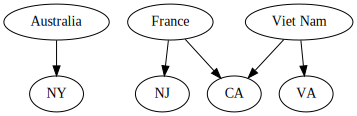

In [29]:
#Q13: what is the geographic overlap in interest between Australia, France, and Viet Nam?

d

In [30]:
#Q14: what are the most commonly seen street addresses?

address_list = []
for log in range(len(server_log)):
    cik = server_log["cik"][log].astype(int).astype(str)
    accession = server_log["accession"][log]
    extention = server_log["extention"][log]
    file = cik + "/" + accession + "/" + extention 
    if file in docs_dict:
        filing_obj = docs_dict[file]
        addresses = filing_obj.addresses
        address_list.append(addresses)
    
address_dict = {}

for item in address_list:
    for addr in item:
        if addr not in address_dict:
            address_dict[addr] = 0
        if addr in address_dict:
            address_dict[addr] += 1
            
            
HV_addresses = {}
for addr in address_dict:
    if address_dict[addr] >= 225:
        HV_addresses[addr] = address_dict[addr] 
        
HV_addresses

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277}

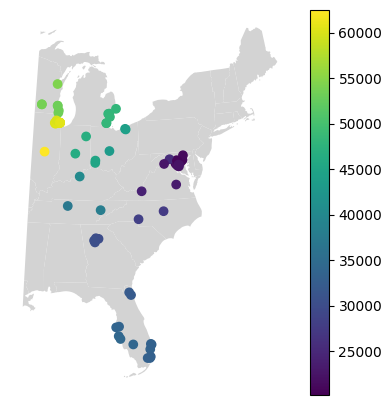

In [31]:
#Q15: geographic plotting of postal code

west = -90
east = -55
north = 50
south = 20

us_portion = box(west, north, east, south) 

path ="shapes/cb_2018_us_state_20m.shp"
backgr_df =gpd.read_file(path)
framed_bckgrnd = backgr_df.intersection(us_portion)
us_bckgrnd = framed_bckgrnd[~framed_bckgrnd.is_empty]

def postal_finder(row):
    post_code = re.findall(r"[A-Z]{2}\s([0-9]{5})", row)
    if post_code != []:
        if int(post_code[0]) >= 20000 and int(post_code[0]) <=70000:
            return int(post_code[0])
        else:
            return None
        
addr_json = gpd.read_file("locations.geojson")
addr_json["postal"] = addr_json["address"].apply(postal_finder)

addr_json = addr_json.dropna()

addr_int = -addr_json.intersection(us_portion).is_empty
point = addr_json[addr_int].to_crs("epsg:2022")
us = us_bckgrnd.to_crs("epsg:2022")
ax = us.plot(figsize=(5, 5), color = "lightgray")
point.plot(ax=ax, column="postal", legend=True, cmap="viridis") 
ax.set_axis_off()